# Imports

In [1]:
import numpy as np
import os
import sys
import pickle
import scipy
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import matplotlib as plt
import statsmodels.api
import statsmodels as sm

## Helper Functions

In [2]:
%store -r analysis_hf
sys.path.insert(0, analysis_hf)

import nodeMapping as nm
import normalize as norm

# Set Directory Paths

In [3]:
# Directory path to load preconstructed Atlas Data
%store -r baseDir

# Directory path to load formatted Pathology Data
%store -r path_dataDir
# Directory path to save Calcualted Analysis Data - Pathology
%store -r path_CalData

# Directory path to load formatted Thickness At Path Data
%store -r thickAtPath_dataDir
# Directory path to save Calcualted Analysis Data
%store -r thickAtPath_CalData
# Directory path to save Figures
%store -r thickAtPath_Fig

# Loading

## Loading the preconstructed atlas data

In [4]:
# loads the preconstructed Atlas data
NetworkDataGeneral = scipy.io.loadmat(os.path.join(baseDir, 'NetworkAnalysisGeneral', 'FTDGeneralData_20221114.mat'))

## Loading Thickness At Path Original (TAU, TDP) - Dropped

In [5]:
# TAUthicknessAtPath_Drop
with open(os.path.join(thickAtPath_dataDir, 'TAUthicknessAtPath_Drop.pkl'), 'rb') as f:
    TAUthicknessAtPath_Drop = pickle.load(f)
f.close()

# TDPthicknessAtPath_Drop
with open(os.path.join(thickAtPath_dataDir, 'TDPthicknessAtPath_Drop.pkl'), 'rb') as f:
    TDPthicknessAtPath_Drop = pickle.load(f)
f.close()

## Loading Dropped Index (=few observations)

In [6]:
# TAU_missing_index
with open(os.path.join(path_CalData, 'TAU_missing_index.pkl'), 'rb') as f:
    TAU_missing_index = pickle.load(f)
f.close()

# TDP_missing_index
with open(os.path.join(path_CalData, 'TDP_missing_index.pkl'), 'rb') as f:
    TDP_missing_index = pickle.load(f)
f.close()

## Loading Pathology Labels (TAU, TDP) - Dropped

In [7]:
# pathNames_TAU_Drop
with open(os.path.join(path_CalData, 'pathNames_TAU_Drop.pkl'), 'rb') as f:
    pathNames_TAU_Drop = pickle.load(f)
f.close()

# pathNames_TDP_Drop
with open(os.path.join(path_CalData, 'pathNames_TDP_Drop.pkl'), 'rb') as f:
    pathNames_TDP_Drop = pickle.load(f)
f.close()

## Loading pathCoM (TAU, TDP) - Dropped

In [8]:
# CoM_TAU_Drop
with open(os.path.join(path_dataDir, 'CoM_TAU_Drop.pkl'), 'rb') as f:
    CoM_TAU_Drop = pickle.load(f)
f.close()

# CoM_TDP_Drop
with open(os.path.join(path_dataDir, 'CoM_TDP_Drop.pkl'), 'rb') as f:
    CoM_TDP_Drop = pickle.load(f)
f.close()

# T-test between TAU vs TDP

## Checking if there is region differences between TAU and TDP due to Drop in Observations

In [9]:
print(TAU_missing_index)
print(TDP_missing_index)

# --> There is no difference

[ 7  8 17 19 27 28 37 39]
[ 7  8 17 19 27 28 37 39]


In [10]:
# Number of regions of Pathology (N = 40)
N = TAUthicknessAtPath_Drop.shape[1]

## T-test. Since the sample numbers are different between TAU and TDP, we would perform Welch's t-test

In [11]:
TAU_gt_TDP_Ttest_stat_list = []
TAU_gt_TDP_Ttest_pval_list = []

TDP_gt_TAU_Ttest_stat_list = []
TDP_gt_TAU_Ttest_pval_list = []


for i in range(N):
    TAU_data = TAUthicknessAtPath_Drop[:, i]
    TDP_data = TDPthicknessAtPath_Drop[:, i]

    # ignore NaN Values in T-test
    TAU_gt_TDP_Ttest = stats.ttest_ind(a=TAU_data, b=TDP_data, equal_var=False, alternative='greater', nan_policy='omit')
    TDP_gt_TAU_Ttest = stats.ttest_ind(a=TAU_data, b=TDP_data, equal_var=False, alternative='less', nan_policy='omit')

    TAU_gt_TDP_Ttest_stat = TAU_gt_TDP_Ttest[0]
    TAU_gt_TDP_Ttest_pval = TAU_gt_TDP_Ttest[1]

    TAU_gt_TDP_Ttest_stat_list.append(TAU_gt_TDP_Ttest_stat)
    TAU_gt_TDP_Ttest_pval_list.append(TAU_gt_TDP_Ttest_pval)

    TDP_gt_TAU_Ttest_stat = TDP_gt_TAU_Ttest[0]
    TDP_gt_TAU_Ttest_pval = TDP_gt_TAU_Ttest[1]

    TDP_gt_TAU_Ttest_stat_list.append(TDP_gt_TAU_Ttest_stat)
    TDP_gt_TAU_Ttest_pval_list.append(TDP_gt_TAU_Ttest_pval)
    

## Multiple Comparison Correction / alpha = 0.05 / Method: Benjamini/Hochberg (non-negative)

### Corrected for TAU > TDP

In [12]:
TAU_gt_TDP_reject, TAU_gt_TDP_pvals_corrected, alphacSidak, alphacBonf = sm.stats.multitest.multipletests(TAU_gt_TDP_Ttest_pval_list, alpha=0.05,
                                                                                                           method='fdr_bh', is_sorted=False, 
                                                                                                           returnsorted=False)

### Corrected for TDP > TAU

In [13]:
TDP_gt_TAU_reject, TDP_gt_TDP_pvals_corrected, alphacSidak, alphacBonf = sm.stats.multitest.multipletests(TDP_gt_TAU_Ttest_pval_list, alpha=0.05,
                                                                                                          method='fdr_bh', is_sorted=False, 
                                                                                                          returnsorted=False)

## TAU > TDP

In [14]:
# Pandas DataFrame
TAU_gt_TDP_df = pd.DataFrame(np.concatenate((np.array(TAU_gt_TDP_pvals_corrected).reshape((-1, 1)), 
                                             np.array(TAU_gt_TDP_reject).reshape((-1, 1))), axis=1), 
                                             columns=['corrected pval', 'Result'], index=pathNames_TAU_Drop)

TAU_gt_TDP_df['Result'] = TAU_gt_TDP_df['Result'].astype('bool')

In [15]:
TAU_gt_TDP_df

,corrected pval,Result
ANG_L,0.999176,False
ATC_L,0.999176,False
HIP_L,0.999176,False
IFC_L,0.999176,False
M1_L,0.999176,False
MFC_L,0.999176,False
OFC_L,0.999176,False
SMTC_L,0.999176,False
SPC_L,0.999176,False
V1_L,0.999176,False


## TDP > TAU

In [16]:
# Pandas DataFrame
TDP_gt_TAU_df = pd.DataFrame(np.concatenate((np.array(TDP_gt_TDP_pvals_corrected).reshape((-1, 1)), 
                                             np.array(TDP_gt_TAU_reject).reshape((-1, 1))), axis=1), 
                                             columns=['corrected pval', 'Result'], index=pathNames_TDP_Drop)

TDP_gt_TAU_df['Result'] = TDP_gt_TAU_df['Result'].astype('bool')

In [17]:
TDP_gt_TAU_df

,corrected pval,Result
ANG_L,0.108942,False
ATC_L,0.013811,True
HIP_L,0.059577,False
IFC_L,0.116595,False
M1_L,0.059577,False
MFC_L,0.058428,False
OFC_L,0.120158,False
SMTC_L,0.152977,False
SPC_L,0.163243,False
V1_L,0.329826,False


# Save T-test results as csv

In [18]:
# Original
TAU_gt_TDP_df.to_csv(thickAtPath_Fig + '/TAU_gt_TDP_Ttest(thick_Original).csv', index=True)

TDP_gt_TAU_df.to_csv(thickAtPath_Fig + '/TDP_gt_TAU_Ttest(thick_Original).csv', index=True)


# 3D Nodes Mapping of Log %AO

### Define Vectors for Node Size and Node Color

In [19]:
# FOR NODE SIZE 
TAUthicknessAtPath_w_exp = TAUthicknessAtPath_Drop
TDPthicknessAtPath_w_exp = TDPthicknessAtPath_Drop

# Get the MAX/MIN Thickness values
minthickAtPath_TAU = np.nanmin(np.nanmean(TAUthicknessAtPath_w_exp, axis=0))
minthickAtPath_TDP = np.nanmin(np.nanmean(TDPthicknessAtPath_w_exp, axis=0))

vanishing_val = 0.2
maxthickAtPath_TAU = np.nanmax(np.nanmean(TAUthicknessAtPath_w_exp, axis=0) - minthickAtPath_TAU) + vanishing_val
maxthickAtPath_TDP = np.nanmax(np.nanmean(TDPthicknessAtPath_w_exp, axis=0) - minthickAtPath_TDP) + vanishing_val

# Get Nodesize / normalized using mean values!
markerVecTAU = np.nanmean(TAUthicknessAtPath_w_exp, axis=0)
markerVecTAU = 3 * (1 - ((markerVecTAU - minthickAtPath_TAU) / maxthickAtPath_TAU))

markerVecTDP = np.nanmean(TDPthicknessAtPath_w_exp, axis=0)
markerVecTDP = 3 * (1 - ((markerVecTDP - minthickAtPath_TDP) / maxthickAtPath_TDP))

# Node color 
# --> If Null Hypothesis rejected: 4
# --> If Null Hypothesis cannotbe rejected: 1
colorVecTAU = np.where(TAU_gt_TDP_reject.astype('int') + 1 == 2, 4, TAU_gt_TDP_reject.astype('int') + 1)
colorVecTDP = np.where(TDP_gt_TAU_reject.astype('int') + 1 == 2, 4, TDP_gt_TAU_reject.astype('int') + 1)

## TAU

/Users/hyroh/Desktop/FTD_Research/mBIN/FTD_JupyterNotebook/HelperFunctions/Analysis_HelperFuntions/nodeMapping.py:107: UserWarning: The figure layout has changed to tight
  plt.tight_layout() # Makes the mapping tighter --> Bigger


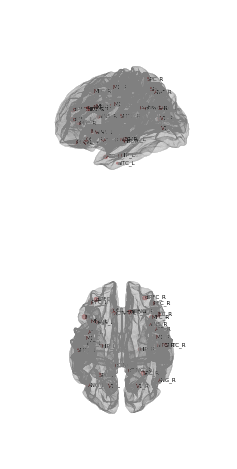

In [20]:
nm.nodeMapping(NetworkDataGeneral, CoM_TAU_Drop, pathNames_TAU_Drop, markerVecTAU, colorVecTAU, thickAtPath_Fig, 
               'Node_3D_Mapping_TAU(Thickness_Original)',
               nodeTransparency = 0.3, atlasTransparency = 0.01, showLabels = 1, surfDisp=None)

## TDP

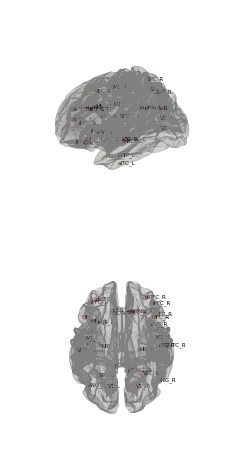

In [21]:
nm.nodeMapping(NetworkDataGeneral, CoM_TDP_Drop, pathNames_TDP_Drop, markerVecTDP, colorVecTDP, thickAtPath_Fig, 
               'Node_3D_Mapping_TDP(Thickness_Original)',
               nodeTransparency = 0.3, atlasTransparency = 0.01, showLabels = 1, surfDisp=None)